In [1]:
import pandas as pd 
import numpy as np
import time
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report, roc_auc_score, matthews_corrcoef
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import LinearSVC,SVR
from sklearn.feature_selection import RFECV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import Binarizer
import matplotlib.pyplot as plt
from pylab import xticks, yticks
from sklearn.calibration import calibration_curve


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# some utils functions

## remove stopwords (some words are meaningless in classification, like function, test)
def remove_stopwords(text):
    text = str(text).lower().strip()
    tokens = []
    for token in text:
        if token not in stop_words:
            tokens.append(token)
            
    return "".join(tokens)

def remove_comments(text):
    no_comments = re.sub(r'#.*', '', text)
    no_comments = re.sub(r'/\*.*\/\*', '', no_comments)
    no_comments = re.sub(r'\d+','',no_comments)
    no_comments = re.sub(r'_', ' ', no_comments)
    no_comments = re.sub(r'[][@$%:!#~/\\?*""()={}''<>.+-;]','', no_comments)
    return no_comments

def remove_cammel(text):
    no_cammel = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', text)).lower().split()
    return no_cammel

In [4]:

stop_words = ['main', 'new', 'subtest','mock','test','public','void','init', 'class', 'name', 'com', 'is', 'prepare',\
    'it', 'cn', 'com', 'runtests', 'testing', 'fuc','tests', 'atomic','ca','bs', 'dc','this', 'on', 'std', 'flaky', 'we',\
    'auto', 'it', 'to','def', 'self', 'base', 'left', 'hello', 'block', 'cli', 'all', 'from', 'import', 'id', 'result', \
    'run', 'cmd','mock','xd', 'yoda','country', 'class', 'out', 'this', 'on', 'std', 'flaky', 'we', 'auto','size', 'not', 'by', \
    'be','activejobs','back']

# describe the classifiers and parameters
classifiers = {
    'randomForest': RandomForestClassifier(random_state=1),
    'decisionTree': DecisionTreeClassifier(min_samples_leaf=1),
    'naiveBayes': GaussianNB(),
    'smo': CalibratedClassifierCV(LinearSVC(fit_intercept=False, tol=0.001, C=1, dual=False, max_iter=100000), method='sigmoid'),
    'knn': KNeighborsClassifier(n_neighbors=1, metric='euclidean'),
    'logisticRegression': LogisticRegression(max_iter=1000),
    'perceptron': CalibratedClassifierCV(Perceptron()),
    'lda': LinearDiscriminantAnalysis(),
}

## cross validation classification
def classify_with_cv(classifiers,x, y, random_state=123, cv = None, shuffle=True, normalize=[]):
    
    labels = ['Flaky', 'NonFlaky']
    results = pd.DataFrame()
    
    scaler = Binarizer(threshold=0.0,).fit(x)
    x_norm = scaler.transform(x)
    
    for key, classifier in classifiers.items():
        if (key in normalize):
            x = x_norm
         
        # classifier.fit(x_train, y_train)
        # classifier.score(x_test, y_test)
        score = cross_val_score(classifier, x, y, cv = cv, scoring='accuracy')
        predict = cross_val_predict(classifier, x, y, cv=cv, method='predict')
        # y_probs = classifier.predict_proba(x_test)[:,1]
        
        result = {
                'classifier': key,
                'f1score': f1_score(y, predict, average='weighted'),
                'accuracy': np.mean(score),
                'confusionMatrix': confusion_matrix(y, predict),
                # 'execution': round_float(get_time(start_time)),
                'classificationReport': classification_report(y, predict, output_dict=True),
                # 'AUC': roc_auc_score(y_test, y_probs),
                'MCC': matthews_corrcoef(y, predict),
                
            }
            # results = pd.concat([results, result], ignore_index=True)
        # print( result)
        # print('\n')
        results = results._append(result, ignore_index=True)
        
        
    return results

### feature importance selection
def feature_importance(x, y):
    
    estimator = RandomForestClassifier(random_state=123)
    estimator.fit(x, y)
    importance = estimator.feature_importances_
    
    return importance


def classify(x_train, x_test, y_train, y_test, classifiers, normalize=[]):
    
    labels = ['Flaky', 'NonFlaky']
    results = pd.DataFrame()
    
    comparison_values = {}
    
    # create a normalized version
    train_scaler = Binarizer(threshold=0.0,).fit(x_train)
    test_scaler = Binarizer(threshold=0.0).fit(x_test)
    x_train_norm = train_scaler.transform(x_train)
    x_test_norm = test_scaler.transform(x_test)
    
    for key, classifier in classifiers.items():
        
        x_train_exec = x_train 
        x_test_exec = x_test
        y_train_exec = y_train
        y_test_exec = y_test
        
        if (key in normalize):
            x_train_exec = x_train_norm
            x_test_exec = x_test_exec
        
        classifier.fit(x_train_exec, y_train)
        classifier.score(x_test_exec, y_test)
        
        predict = classifier.predict(x_test_exec)
        y_probs = classifier.predict_proba(x_test_exec)[:,1]
        
        
        result = {
            'classifier': key,
            'f1score': f1_score(y_test, predict, average='weighted'),
            'accuracy': classifier.score(x_test_exec, y_test),
            'confusionMatrix': confusion_matrix(y_test, predict),
            'classificationReport': classification_report(y_test, predict, output_dict=True),
            'AUC': roc_auc_score(y_test, y_probs),
            'MCC': matthews_corrcoef(y_test, predict),
            
        }

        results = results._append(result, ignore_index=True)

    
    return results    

In [5]:
### load data

data = pd.read_excel('./flaky_data.xlsx')
df = pd.DataFrame(data, columns=['Language', 'project name', 'test case name', 'label','test case content', 'tokens'])

# drop columns "project name" and "test case name"
df.drop('project name', axis=1, inplace=True)
df.drop('test case name', axis=1, inplace=True)

In [6]:
### preprocessing of test case content

df['test case content'] = df['test case content'].apply(lambda x: remove_comments(x))
df['test case content'] = df['test case content'].apply(lambda x: remove_cammel(x))


### create a tokens column for the processed text

df['tokens'] = df['test case content']

In [7]:
### init tokenizer and fit 

tokenizer = TfidfVectorizer(analyzer='word', max_features=1500,stop_words=stop_words)

    
df.tokens = df.tokens.apply(lambda x: remove_stopwords(x))
bow_token = tokenizer.fit_transform(df.tokens)

bow_data = pd.DataFrame(bow_token.toarray(), columns=tokenizer.get_feature_names_out())


In [8]:
y = df.label.copy()
df = pd.concat([df, bow_data], axis=1)
df.label = y

In [9]:
### filter the dataset according to languages

java_df = df[df['Language'] == 'Java']
python_df = df[df['Language'] == 'Python']
go_df = df[df['Language'] == 'go']
cpp_df = df[df['Language'] == 'C++']
js_df = df[df['Language'] == 'JS']

In [10]:
java_js_df = df[df['Language'].isin(['Java', 'JS'])]
java_py_cpp = df[df['Language'].isin(['Java', 'Python', 'C++'])]
no_java = df[~df['Language'].isin(['Java'])]

In [11]:

java_y = java_df.iloc[:, 1:2]
java_x = java_df.drop(columns=['Language', 'label','label', 'test case content', 'tokens'])

python_y = python_df.iloc[:, 1:2]
python_x = python_df.drop(['Language', 'label', 'label','test case content', 'tokens'], axis=1)

cpp_y = cpp_df.iloc[:, 1:2]
cpp_x = cpp_df.drop(['Language', 'label', 'label','test case content', 'tokens'], axis=1)

go_y = go_df.iloc[:, 1:2]
go_x = go_df.drop(['Language', 'label', 'label','test case content', 'tokens'], axis=1)

js_y = js_df.iloc[:, 1:2]
js_x = js_df.drop(['Language', 'label', 'label','test case content', 'tokens'], axis=1)

java_js_y = java_js_df.iloc[:, 1:2]
java_js_x = java_js_df.drop(columns=['Language', 'label','label', 'test case content', 'tokens'])

java_py_cpp_y = java_py_cpp.iloc[:, 1:2]
java_py_cpp_x = java_py_cpp.drop(columns=['Language', 'label','label', 'test case content', 'tokens'])

no_java_y = no_java.iloc[:, 1:2]
no_java_x = no_java.drop(columns=['Language', 'label','label', 'test case content', 'tokens'])

all_y = df.iloc[:, 1:2]
all_x = df.drop(columns=['Language', 'label','label', 'test case content', 'tokens'])

In [12]:
java_importance = feature_importance(java_x, java_y)
print("The top 20 features in Projects are:\n", java_x.columns[np.argsort(-java_importance)[:20]])


The top 20 features in Projects are:
 Index(['throws', 'exception', 'should', 'io', 'equal', 'error', 'int', 'build',
       'for', 'resource', 'assert', 'thrownexpect', 'inode', 'description',
       'column', 'property', 'message', 'finally', 'http', 'if'],
      dtype='object')


In [13]:
python_importance = feature_importance(python_x, python_y)
print("The top 20 features in Projects are: \n", python_x.columns[np.argsort(-python_importance)[:20]])

The top 20 features in Projects are: 
 Index(['true', 'model', 'assert', 'check', 'with', 'app', 'and', 'process',
       'dict', 'appapp', 'context', 'equalerr', 'selfassert', 'batch', 'in',
       'msgs', 'instanceerr', 'fake', 'equallenerr', 'err'],
      dtype='object')


In [14]:
cpp_importance = feature_importance(cpp_x, cpp_y)
print("The top 20 features in Projects are: \n", cpp_x.columns[np.argsort(-cpp_importance)[:20]])

The top 20 features in Projects are: 
 Index(['string', 'case', 'chec', 'wait', 'and', 'op', 'disabled', 'get',
       'expect', 'type', 'event', 'jobs', 'return', 'prob', 'const',
       'character', 'in', 'manager', 'info', 'input'],
      dtype='object')


In [15]:
go_importance = feature_importance(go_x, go_y)
print("The top 20 features in Projects are: \n", go_x.columns[np.argsort(-go_importance)[:20]])

The top 20 features in Projects are: 
 Index(['func', 'if', 'timeout', 'pod', 'time', 'true', 'fake', 'errort',
       'file', 'expected', 'const', 'len', 'return', 'no', 'require', 'up',
       'assert', 'esbuild', 'as', 'nil'],
      dtype='object')


In [16]:
java_js_importance = feature_importance(java_js_x, java_js_y)
print("The top 20 features in Projects are: \n", java_js_x.columns[np.argsort(-java_importance)[:20]])

The top 20 features in Projects are: 
 Index(['throws', 'exception', 'should', 'io', 'equal', 'error', 'int', 'build',
       'for', 'resource', 'assert', 'thrownexpect', 'inode', 'description',
       'column', 'property', 'message', 'finally', 'http', 'if'],
      dtype='object')


In [17]:
java_py_cpp_importance = feature_importance(java_py_cpp_x, java_py_cpp_y)
print("The top 20 features in Projects are: \n", java_py_cpp_x.columns[np.argsort(-java_py_cpp_importance)[:20]])

The top 20 features in Projects are: 
 Index(['throws', 'exception', 'should', 'io', 'error', 'equal', 'int',
       'resource', 'for', 'build', 'inode', 'assert', 'description', 'column',
       'byte', 'string', 'selfassert', 'table', 'message', 'http'],
      dtype='object')


In [18]:
no_java_importance = feature_importance(no_java_x, no_java_y)
print("The top 20 features in Projects are: \n", no_java_x.columns[np.argsort(-no_java_importance)[:20]])

The top 20 features in Projects are: 
 Index(['string', 'case', 'in', 'true', 'func', 'chec', 'assert', 'function',
       'check', 'with', 'selfassert', 'config', 'context', 'get', 'false',
       'unittest', 'err', 'query', 'https', 'instanceerr'],
      dtype='object')


In [19]:
all_importance = feature_importance(all_x, all_y)
print("The top 20 features in Projects are: \n", all_x.columns[np.argsort(-all_importance)[:20]])

The top 20 features in Projects are: 
 Index(['throws', 'exception', 'should', 'io', 'equal', 'for', 'error', 'int',
       'string', 'assert', 'build', 'selfassert', 'description', 'resource',
       'in', 'type', 'column', 'inode', 'byte', 'message'],
      dtype='object')


In [20]:
java_results = classify_with_cv(classifiers, java_x, java_y, cv=10, normalize=['knn'])
python_results = classify_with_cv(classifiers, python_x, python_y, cv=10, normalize=['knn'])
cpp_results = classify_with_cv(classifiers, cpp_x, cpp_y, cv=10, normalize=['knn'])
go_results = classify_with_cv(classifiers, go_x, go_y, cv=10, normalize=['knn'])
java_js_results = classify_with_cv(classifiers, java_js_x, java_js_y, cv=10, normalize=['knn'])
java_py_cpp_results = classify_with_cv(classifiers, java_py_cpp_x, java_py_cpp_y, cv=10, normalize=['knn'])
nojava_results = classify_with_cv(classifiers, no_java_x, no_java_y, cv=10, normalize=['knn'])
all_results = classify_with_cv(classifiers, all_x, all_y, cv=10, normalize=['knn'])

In [21]:
output = pd.concat([java_results, python_results, cpp_results, go_results, java_js_results, java_py_cpp_results, nojava_results, all_results], axis=0)
output.to_excel('./output_results.xlsx')

In [22]:
f1scores = np.array([java_results.f1score, python_results.f1score, cpp_results.f1score, go_results.f1score, 
                     java_js_results.f1score, java_py_cpp_results.f1score, nojava_results.f1score, all_results.f1score])
accuracys = np.array([java_results.accuracy, python_results.accuracy, cpp_results.accuracy, go_results.accuracy, 
                     java_js_results.accuracy, java_py_cpp_results.accuracy, nojava_results.accuracy, all_results.accuracy])

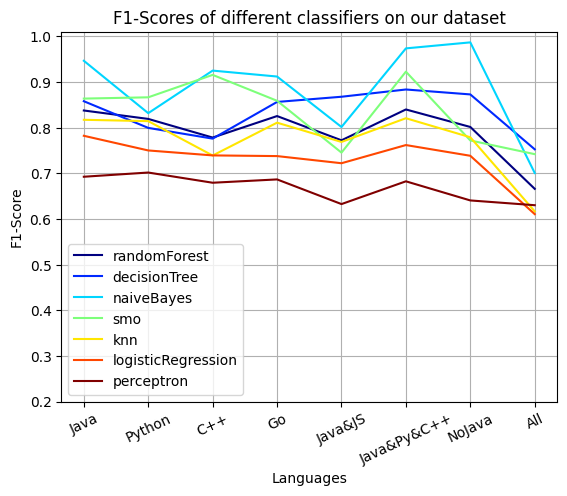

In [23]:
## comment the lines you do not need to generate your expected figure
vis_data = f1scores
# vis_data = accuracys
fig = plt.plot(figsize=(30,30))


plt.xlabel('Languages')
plt.ylabel('F1-Score')
plt.grid()
plt.ylim([0.2, 1.01])
colors = plt.cm.jet(np.linspace(0,1,7))
xticks_labels = ['Java', 'Python', 'C++', 'Go', 'Java&JS', 'Java&Py&C++', 'NoJava', 'All']
xticks(np.linspace(0, 7, 8, endpoint=True), xticks_labels, rotation=25)
plt.plot(xticks_labels, vis_data[0,:], '-', color=colors[0],label=list(classifiers.keys())[0])
plt.plot(xticks_labels, vis_data[1,:], '-', color=colors[1], label=list(classifiers.keys())[1])
plt.plot(xticks_labels, vis_data[2,:], '-', color=colors[2], label=list(classifiers.keys())[2])
plt.plot(xticks_labels, vis_data[3,:], '-', color=colors[3], label=list(classifiers.keys())[3])
plt.plot(xticks_labels, vis_data[4,:], '-', color=colors[4], label=list(classifiers.keys())[4])
plt.plot(xticks_labels, vis_data[5,:], '-', color=colors[5], label=list(classifiers.keys())[5])
plt.plot(xticks_labels, vis_data[6,:], '-', color=colors[6], label=list(classifiers.keys())[6])


plt.title('F1-Scores of different classifiers on our dataset')
plt.legend()
plt.show()

In [24]:
def train_test_split_classify(x, y, test_size):
    # x_train, x_test, y_train, y_test, classifiers, normalize=[]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=123)
    results = classify(x_train, x_test, y_train, y_test, classifiers, normalize=['knn'])
    
    return results
    

In [25]:
java_8_2_results = train_test_split_classify(java_x, java_y, 0.2)
python_8_2_results = train_test_split_classify(python_x, python_y, 0.2)
cpp_8_2_results = train_test_split_classify(cpp_x, cpp_y, 0.2)
go_8_2_results = train_test_split_classify(go_x, go_y, 0.2)
java_js_8_2_results = train_test_split_classify(java_js_x, java_js_y, 0.2)
java_py_cpp_8_2_results = train_test_split_classify(java_py_cpp_x, java_py_cpp_y, 0.2)
nojava_8_2_results = train_test_split_classify(no_java_x, no_java_y, 0.2)
all_8_2_results = train_test_split_classify(all_x, all_y, 0.2)

In [26]:
java_7_2_results = train_test_split_classify(java_x, java_y, 0.3)
python_7_2_results = train_test_split_classify(python_x, python_y, 0.3)
cpp_7_2_results = train_test_split_classify(cpp_x, cpp_y, 0.3)
go_7_2_results = train_test_split_classify(go_x, go_y, 0.3)
java_js_7_2_results = train_test_split_classify(java_js_x, java_js_y, 0.3)
java_py_cpp_7_2_results = train_test_split_classify(java_py_cpp_x, java_py_cpp_y, 0.3)
nojava_7_2_results = train_test_split_classify(no_java_x, no_java_y, 0.3)
all_7_2_results = train_test_split_classify(all_x, all_y, 0.3)

In [27]:
output_8_2 = pd.concat([java_8_2_results, python_8_2_results, cpp_8_2_results, go_8_2_results, java_js_8_2_results, java_py_cpp_8_2_results, nojava_8_2_results, all_8_2_results], axis=0)
# output_8_2.to_excel('./output_8_2_results.xlsx')

In [28]:
output_7_2 = pd.concat([java_7_2_results, python_7_2_results, cpp_7_2_results, go_7_2_results, java_js_7_2_results, java_py_cpp_7_2_results, nojava_7_2_results, all_7_2_results], axis=0)
output_7_2.to_excel('./output_7_2_results1.xlsx')